# node2vec

The node2vec method is a network embedding method in the context of traditional link prediction methods. Network embedding methods learn low-dimensional representations, so-called embeddings, for nodes, often based on training a skip-gram model on random-walk-generated node sequences, so that nodes that often appear nearby each other in a random walk, i.e., nodes close in a network, have similar representations. Then, the pairwise node embeddings are aggregated as link representations for link prediction. 

In comparison to DeepWalk, node2vec can be seen as its generalization where $p$ and $q$ can take values other than 1. In node2vec, second-order biased random walks are considered.

The node2vec method is meant to serve as a baseline for later comparison with the three GNNs. It does not take node features into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.helpers import *
import pickle

import json
import os
import time
import random

import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression

import node2vec_functions 
from gensim.models import Word2Vec

In [2]:
# Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    #np.random.seed(1234)
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean validation average precision is:', df_best[variable].unique()[0])

## Creation of graph and adjacency matrix

Our implementation of node2vec consists of different parts: we first create a node2vec graph instance and generate the walks, we then learn the word embeddings for the nodes in the training graph and create a node embeddings matrix and then use the node embeddings to obtain the edge embeddings, which are then used for link prediction.

As preliminary work, we first need to load the links of our original graph, create a networkx graph from them using `nx.Graph()` and calculate the adjacency matrix of this networkx graph, which comes in SciPy sparse format.

In [7]:
# read in all_links
with open('./all_links.txt', 'r') as f:
    all_links = json.loads(f.read())

In [8]:
# create graph and adjacency matrix
g = nx.Graph(all_links)
adj = nx.adjacency_matrix(g)

We now plot the graph to get a better impression of it.

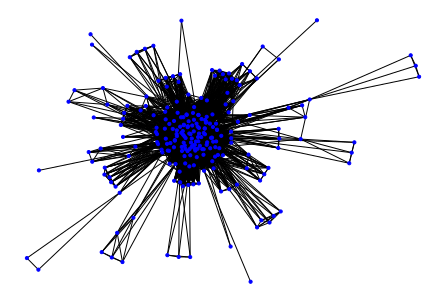

In [9]:
# draw network
np.random.seed(1234)
plt.figure(figsize=(6,4))
graph=nx.draw(g, with_labels=False, node_size=10, node_color='b')

It is evident that one group of HCPs has many connections to other HCPs, while another group of HCPs has only very few connections to other HCPs.

## Training loop

In our training loop, we use the following train-validation-test split: The training set contains a fraction of 0.6 of all 5821 links of our original graph, the validation set contains a fraction of 0.1 of all 5821 links of our original graph and the test set contains a fraction of 0.3 of all 5821 links of our original graph.

The 5821 links referred to above are links that actually exist and can therefore also be called *positive edges*. Links that do not actually exist in a graph are called *negative edges*.

In addition to the positive training, validation and test edges - called `train_edges`, `val_edges` and `test_edges` below, an equal number of negative training, validation and test edges - called `train_edges_false`, `val_edges_false` and `test_edges_false` below - are also extracted. The reason why negative edges are also extracted is that we want to determine not only how reliably the presence of a positive edge is predicted, but also how reliably the absence of a negative edge is predicted.  

We perform 10 runs with different train-validation-test splits, where the respective fractions of 0.6, 0.1 and 0.3 of course always remain unchanged.

The training loop calculates the validation AUCs and APs, test AUCs and APs in the 10 runs as well as the mean validation AUC and AP, mean test AUC and AP, standard deviation of validation AUCs and APs, standard deviation of test AUCs and APs over the 10 runs. We save all results in `nv_results`.

## Hyperparameter tuning

We use the functions from the file `node2vec_functions.py` and the [gensim implementation of Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html), where the first part is used to create a node2vec graph instance and generate the walks and the second part is used to train a skip-gram model.
With our node2vec implementation, the train these two hyperparameters:

* `P`: return parameter. Used in first part.
* `Q`: in-out parameter. Used in first part.

The other hyperparameters are not trained to prevent excessive running times. For them, we take the values from the best hyperparameter combination of DeepWalk. The other hyperparameters are:

* `window_size`: context size for optimization. Used in second part. Set to 5.
* `num_walks`: number of walks per source. Used in first part. Set to 20.
* `walk_length`: length of walk per source. Used in first part. Set to 40.
* `dimensions`: embedding dimension. Used in second part. Set to 128.
* `min_count` : set to 0.
* `sg`: set to 1 (to obtain skip-gram model).
* `iter`: set to 1.

Furthermore, we set `directed = False`, `verbose = False` to prevent excessive printing and `workers = 1` for
reproducibility. 

There are still other hyperparameters that can be tuned. We do not tune them and instead rely on their default values provided in gensim. We now perform the hyperparameter tuning using loops.

Note that we need to seed with np and random and also in Word2Vec. In order for seeding to work in Word2vec, WORKERS = 1 must be set.

In [10]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [11]:
start_time = time.time()

nv_results = pd.DataFrame(columns = ['parameters', 'val_auc', 'val_ap', 'test_auc', 'test_ap', 'mean_val_auc', 'mean_val_ap', 
                                     'mean_test_auc','mean_test_ap', 'std_val_auc', 'std_val_ap', 'std_test_auc', 
                                     'std_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

is_directed = False
min_count = 0
sg = 1
WORKERS = 1 
ITER = 1
verbose = False

# Loops for hyperparameter tuning
for P in [1, 2, 3, 4, 5]: 
    for Q in [1, 2, 3, 4, 5]: 
        for WINDOW_SIZE in [5]: # 5, 10
            for NUM_WALKS in [20]: # 10, 20
                for WALK_LENGTH in [80]: # 40, 80
                    for DIMENSIONS in [128]: # 16, 32, 64, 128 
        
                        print(f'====================================================================================================\nParameter combination: {{P: {P}, Q: {Q}, WINDOW_SIZE: {WINDOW_SIZE}, NUM_WALKS: {NUM_WALKS}, WALK_LENGTH: {WALK_LENGTH}, DIMENSIONS: {DIMENSIONS}}}\n====================================================================================================')

                        parameter_dict = dict({'P': P, 'Q': Q, 'WINDOW_SIZE': WINDOW_SIZE, 'NUM_WALKS': NUM_WALKS, 'WALK_LENGTH': WALK_LENGTH, 'DIMENSIONS': DIMENSIONS})

                        val_auc_dict = dict()
                        val_ap_dict = dict()
                        test_auc_dict = dict()
                        test_ap_dict = dict()

                        for i, seed in enumerate(seeds):

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            np.random.seed(seed)
                            random.seed(seed)
                            #torch_geometric.seed_everything(seed) 

                            # Perform train-validation-test split
                            adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
                                test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)
                            g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

                            # Preprocessing, generate walks
                            g_n2v = node2vec_functions.Graph(g_train, is_directed, P, Q) # create node2vec graph instance
                            g_n2v.preprocess_transition_probs()
                            walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH, verbose)
                            walks = [list(map(str, walk)) for walk in walks] # changed to list(map(...)) from originally map(...)

                            # Train skip-gram model
                            model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count = min_count, sg = sg, workers = WORKERS, iter=ITER, seed=seed)

                            # Store embeddings mapping
                            emb_mappings = model.wv

                            # Create node embeddings matrix (rows = nodes, columns = embedding features)
                            emb_list = []
                            for node_index in range(0, adj.shape[0]):
                                node_str = str(node_index)
                                node_emb = emb_mappings[node_str]
                                emb_list.append(node_emb)
                            emb_matrix = np.vstack(emb_list)

                            # Train-set edge embeddings
                            pos_train_edge_embs = get_edge_embeddings(train_edges)
                            neg_train_edge_embs = get_edge_embeddings(train_edges_false)
                            train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

                            # Create train-set edge labels: 1 = real edge, 0 = false edge
                            train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

                            # Val-set edge embeddings, labels
                            pos_val_edge_embs = get_edge_embeddings(val_edges)
                            neg_val_edge_embs = get_edge_embeddings(val_edges_false)
                            val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
                            val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

                            # Test-set edge embeddings, labels
                            pos_test_edge_embs = get_edge_embeddings(test_edges)
                            neg_test_edge_embs = get_edge_embeddings(test_edges_false)
                            test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

                            # Create val-set edge labels: 1 = real edge, 0 = false edge
                            test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

                            # Train logistic regression classifier on train-set edge embeddings
                            edge_classifier = LogisticRegression()
                            edge_classifier.fit(train_edge_embs, train_edge_labels)

                            # Predicted edge scores: probability of being of class "1" (real edge)
                            val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
                            val_auc = roc_auc_score(val_edge_labels, val_preds)
                            val_ap = average_precision_score(val_edge_labels, val_preds)

                            # Predicted edge scores: probability of being of class "1" (real edge)
                            test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
                            test_auc = roc_auc_score(test_edge_labels, test_preds)
                            test_ap = average_precision_score(test_edge_labels, test_preds)

                            print(f'Validation AUC: {val_auc:.4f}, Validation AP: {val_ap:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

                            val_auc_dict.update({f"{i+1}": val_auc})
                            val_ap_dict.update({f"{i+1}": val_ap})    
                            test_auc_dict.update({f"{i+1}": test_auc})
                            test_ap_dict.update({f"{i+1}": test_ap})   

                        data_concat = [{'parameters': parameter_dict, 'val_auc': val_auc_dict, 'val_ap': val_ap_dict, 'test_auc': test_auc_dict, 
                                        'test_ap': test_ap_dict, 'mean_val_auc': mean(val_auc_dict.values()), 
                                        'mean_val_ap': mean(val_ap_dict.values()), 'mean_test_auc': mean(test_auc_dict.values()), 
                                        'mean_test_ap': mean(test_ap_dict.values()), 'std_val_auc': std(val_auc_dict.values()), 
                                        'std_val_ap': std(val_ap_dict.values()), 'std_test_auc': std(test_auc_dict.values()), 
                                        'std_test_ap': std(test_ap_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        nv_results = pd.concat([nv_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to nv_results.pkl")
nv_results.to_pickle(f"{route0}/nv_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {P: 1, Q: 1, WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 128}
Run 1 with seed 12345:
Validation AUC: 0.8394, Validation AP: 0.8207, Test AUC: 0.8566, Test AP: 0.8318
Run 2 with seed 23456:
Validation AUC: 0.8336, Validation AP: 0.7900, Test AUC: 0.8111, Test AP: 0.7649
Run 3 with seed 34567:
Validation AUC: 0.8580, Validation AP: 0.8117, Test AUC: 0.8619, Test AP: 0.8342
Run 4 with seed 45678:
Validation AUC: 0.8431, Validation AP: 0.8177, Test AUC: 0.8511, Test AP: 0.8237
Run 5 with seed 56789:
Validation AUC: 0.8382, Validation AP: 0.8085, Test AUC: 0.8372, Test AP: 0.7892
Run 6 with seed 54321:
Validation AUC: 0.8548, Validation AP: 0.8263, Test AUC: 0.8333, Test AP: 0.7937
Run 7 with seed 65432:
Validation AUC: 0.8443, Validation AP: 0.8049, Test AUC: 0.8266, Test AP: 0.7891
Run 8 with seed 76543:
Validation AUC: 0.8718, Validation AP: 0.8490, Test AUC: 0.8481, Test AP: 0.8090
Run 9 with seed 87654:
Validation AUC: 0.8610, Validation AP: 0.826

Validation AUC: 0.8932, Validation AP: 0.8793, Test AUC: 0.8952, Test AP: 0.8736
Run 6 with seed 54321:
Validation AUC: 0.9187, Validation AP: 0.9103, Test AUC: 0.9103, Test AP: 0.8965
Run 7 with seed 65432:
Validation AUC: 0.9065, Validation AP: 0.8883, Test AUC: 0.9029, Test AP: 0.8791
Run 8 with seed 76543:
Validation AUC: 0.9230, Validation AP: 0.9065, Test AUC: 0.8935, Test AP: 0.8687
Run 9 with seed 87654:
Validation AUC: 0.8986, Validation AP: 0.8605, Test AUC: 0.9069, Test AP: 0.8877
Run 10 with seed 98765:
Validation AUC: 0.8791, Validation AP: 0.8513, Test AUC: 0.9019, Test AP: 0.8874
Parameter combination: {P: 1, Q: 5, WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 128}
Run 1 with seed 12345:
Validation AUC: 0.9096, Validation AP: 0.8918, Test AUC: 0.9062, Test AP: 0.8817
Run 2 with seed 23456:
Validation AUC: 0.9196, Validation AP: 0.9008, Test AUC: 0.9034, Test AP: 0.8814
Run 3 with seed 34567:
Validation AUC: 0.9082, Validation AP: 0.8930, Test AUC: 0.9092, T

Validation AUC: 0.8684, Validation AP: 0.8446, Test AUC: 0.8809, Test AP: 0.8551
Run 2 with seed 23456:
Validation AUC: 0.8907, Validation AP: 0.8703, Test AUC: 0.8657, Test AP: 0.8417
Run 3 with seed 34567:
Validation AUC: 0.8880, Validation AP: 0.8604, Test AUC: 0.8993, Test AP: 0.8810
Run 4 with seed 45678:
Validation AUC: 0.8748, Validation AP: 0.8544, Test AUC: 0.8804, Test AP: 0.8459
Run 5 with seed 56789:
Validation AUC: 0.8689, Validation AP: 0.8465, Test AUC: 0.8791, Test AP: 0.8563
Run 6 with seed 54321:
Validation AUC: 0.8866, Validation AP: 0.8759, Test AUC: 0.8761, Test AP: 0.8574
Run 7 with seed 65432:
Validation AUC: 0.8990, Validation AP: 0.8827, Test AUC: 0.8831, Test AP: 0.8592
Run 8 with seed 76543:
Validation AUC: 0.9114, Validation AP: 0.8941, Test AUC: 0.8765, Test AP: 0.8388
Run 9 with seed 87654:
Validation AUC: 0.8942, Validation AP: 0.8575, Test AUC: 0.8980, Test AP: 0.8818
Run 10 with seed 98765:
Validation AUC: 0.8488, Validation AP: 0.8266, Test AUC: 0.8832

Validation AUC: 0.8334, Validation AP: 0.7791, Test AUC: 0.8108, Test AP: 0.7665
Run 8 with seed 76543:
Validation AUC: 0.8610, Validation AP: 0.8210, Test AUC: 0.8336, Test AP: 0.7850
Run 9 with seed 87654:
Validation AUC: 0.8299, Validation AP: 0.7963, Test AUC: 0.8409, Test AP: 0.8092
Run 10 with seed 98765:
Validation AUC: 0.8139, Validation AP: 0.8023, Test AUC: 0.8446, Test AP: 0.8217
Parameter combination: {P: 3, Q: 2, WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 128}
Run 1 with seed 12345:
Validation AUC: 0.8441, Validation AP: 0.8287, Test AUC: 0.8557, Test AP: 0.8295
Run 2 with seed 23456:
Validation AUC: 0.8772, Validation AP: 0.8552, Test AUC: 0.8536, Test AP: 0.8242
Run 3 with seed 34567:
Validation AUC: 0.8932, Validation AP: 0.8610, Test AUC: 0.8938, Test AP: 0.8702
Run 4 with seed 45678:
Validation AUC: 0.8531, Validation AP: 0.8342, Test AUC: 0.8618, Test AP: 0.8330
Run 5 with seed 56789:
Validation AUC: 0.8624, Validation AP: 0.8485, Test AUC: 0.8775, T

Validation AUC: 0.8936, Validation AP: 0.8869, Test AUC: 0.8941, Test AP: 0.8717
Run 2 with seed 23456:
Validation AUC: 0.9010, Validation AP: 0.8873, Test AUC: 0.8835, Test AP: 0.8649
Run 3 with seed 34567:
Validation AUC: 0.9077, Validation AP: 0.8948, Test AUC: 0.9149, Test AP: 0.9080
Run 4 with seed 45678:
Validation AUC: 0.8967, Validation AP: 0.8752, Test AUC: 0.9016, Test AP: 0.8830
Run 5 with seed 56789:
Validation AUC: 0.8888, Validation AP: 0.8836, Test AUC: 0.8969, Test AP: 0.8821
Run 6 with seed 54321:
Validation AUC: 0.8917, Validation AP: 0.8786, Test AUC: 0.8849, Test AP: 0.8719
Run 7 with seed 65432:
Validation AUC: 0.9065, Validation AP: 0.8994, Test AUC: 0.8971, Test AP: 0.8809
Run 8 with seed 76543:
Validation AUC: 0.9125, Validation AP: 0.8942, Test AUC: 0.8782, Test AP: 0.8466
Run 9 with seed 87654:
Validation AUC: 0.9070, Validation AP: 0.8849, Test AUC: 0.9106, Test AP: 0.9020
Run 10 with seed 98765:
Validation AUC: 0.8766, Validation AP: 0.8615, Test AUC: 0.9017

Validation AUC: 0.8818, Validation AP: 0.8553, Test AUC: 0.8646, Test AP: 0.8426
Run 8 with seed 76543:
Validation AUC: 0.8853, Validation AP: 0.8739, Test AUC: 0.8514, Test AP: 0.8233
Run 9 with seed 87654:
Validation AUC: 0.8852, Validation AP: 0.8458, Test AUC: 0.9019, Test AP: 0.8918
Run 10 with seed 98765:
Validation AUC: 0.8466, Validation AP: 0.8342, Test AUC: 0.8720, Test AP: 0.8607
Parameter combination: {P: 4, Q: 4, WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 128}
Run 1 with seed 12345:
Validation AUC: 0.8879, Validation AP: 0.8833, Test AUC: 0.8878, Test AP: 0.8702
Run 2 with seed 23456:
Validation AUC: 0.9043, Validation AP: 0.8834, Test AUC: 0.8834, Test AP: 0.8543
Run 3 with seed 34567:
Validation AUC: 0.8980, Validation AP: 0.8737, Test AUC: 0.9022, Test AP: 0.8848
Run 4 with seed 45678:
Validation AUC: 0.8871, Validation AP: 0.8668, Test AUC: 0.8959, Test AP: 0.8735
Run 5 with seed 56789:
Validation AUC: 0.8827, Validation AP: 0.8641, Test AUC: 0.8878, T

Validation AUC: 0.8480, Validation AP: 0.8309, Test AUC: 0.8479, Test AP: 0.8208
Run 2 with seed 23456:
Validation AUC: 0.8803, Validation AP: 0.8618, Test AUC: 0.8467, Test AP: 0.8189
Run 3 with seed 34567:
Validation AUC: 0.8785, Validation AP: 0.8515, Test AUC: 0.8811, Test AP: 0.8591
Run 4 with seed 45678:
Validation AUC: 0.8453, Validation AP: 0.8117, Test AUC: 0.8558, Test AP: 0.8185
Run 5 with seed 56789:
Validation AUC: 0.8519, Validation AP: 0.8336, Test AUC: 0.8604, Test AP: 0.8304
Run 6 with seed 54321:
Validation AUC: 0.8589, Validation AP: 0.8356, Test AUC: 0.8459, Test AP: 0.8156
Run 7 with seed 65432:
Validation AUC: 0.8659, Validation AP: 0.8393, Test AUC: 0.8406, Test AP: 0.8103
Run 8 with seed 76543:
Validation AUC: 0.8799, Validation AP: 0.8584, Test AUC: 0.8469, Test AP: 0.8070
Run 9 with seed 87654:
Validation AUC: 0.8634, Validation AP: 0.8308, Test AUC: 0.8748, Test AP: 0.8580
Run 10 with seed 98765:
Validation AUC: 0.8175, Validation AP: 0.8057, Test AUC: 0.8401

Validation AUC: 0.9087, Validation AP: 0.9010, Test AUC: 0.8995, Test AP: 0.8804
Run 8 with seed 76543:
Validation AUC: 0.9197, Validation AP: 0.9112, Test AUC: 0.8829, Test AP: 0.8647
Run 9 with seed 87654:
Validation AUC: 0.8946, Validation AP: 0.8771, Test AUC: 0.9097, Test AP: 0.9007
Run 10 with seed 98765:
Validation AUC: 0.8626, Validation AP: 0.8486, Test AUC: 0.8967, Test AP: 0.8884
saving file corresponding to nv_results.pkl
1 hours 42.69 minutes


In [ ]:
# saving file corresponding to nv_results.pkl
# 1 hours 42.69 minutes

In [12]:
# Look at results
nv_results = pd.read_pickle(f"{route0}/nv_results.pkl") 
nv_results

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
0,"{'P': 1, 'Q': 1, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8394149809284255, '2': 0.8336197021764...","{'1': 0.820694714265849, '2': 0.79002082358866...","{'1': 0.8566325385859874, '2': 0.8111018607086...","{'1': 0.831763346571302, '2': 0.76488361812726...",0.845674,0.812910,0.842281,0.806836,0.015815,0.019719,0.015050,0.021777
1,"{'P': 1, 'Q': 2, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8746767279555034, '2': 0.8800970701810...","{'1': 0.8556002835872184, '2': 0.8520587569310...","{'1': 0.8798864759115583, '2': 0.8560145329727...","{'1': 0.8541667114628742, '2': 0.8186003627106...",0.877227,0.852272,0.875785,0.846851,0.012156,0.011995,0.011915,0.016557
2,"{'P': 1, 'Q': 3, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.9071544974669642, '2': 0.8913894498175...","{'1': 0.8938929521852381, '2': 0.8712941926146...","{'1': 0.9011843795472945, '2': 0.8754377539760...","{'1': 0.8766101609950294, '2': 0.8475154593745...",0.890755,0.867755,0.890146,0.865018,0.013143,0.018258,0.008089,0.009785
3,"{'P': 1, 'Q': 4, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.9083678747298685, '2': 0.9077213306408...","{'1': 0.8963124960995439, '2': 0.8853444917798...","{'1': 0.9021910988822103, '2': 0.8856122126306...","{'1': 0.8758536777550676, '2': 0.8532226077727...",0.905085,0.885430,0.901273,0.879477,0.011904,0.017412,0.007252,0.011773
4,"{'P': 1, 'Q': 5, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.9096314403467131, '2': 0.9196395885735...","{'1': 0.8918379144026578, '2': 0.9008129468911...","{'1': 0.906151386445077, '2': 0.90336576878717...","{'1': 0.8817046026137173, '2': 0.8813833497599...",0.907859,0.889429,0.907120,0.887638,0.013905,0.017271,0.004902,0.009721
5,"{'P': 2, 'Q': 1, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8219612427817339, '2': 0.8475189239616...","{'1': 0.7925708978620326, '2': 0.8019284147008...","{'1': 0.8355800002361806, '2': 0.8097087238512...","{'1': 0.7981038024791074, '2': 0.7579793549940...",0.834589,0.800329,0.831498,0.791880,0.017544,0.017243,0.017941,0.024699
6,"{'P': 2, 'Q': 2, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8534588632633059, '2': 0.8668030608991...","{'1': 0.823835988588991, '2': 0.84329018962893...","{'1': 0.8578380431659207, '2': 0.8449822799027...","{'1': 0.822920853324033, '2': 0.81495766225799...",0.868062,0.842522,0.867296,0.839232,0.013880,0.014183,0.013118,0.017838
7,"{'P': 2, 'Q': 3, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8683707088957381, '2': 0.8907133831674...","{'1': 0.844640170804718, '2': 0.87027744190632...","{'1': 0.8809466638849854, '2': 0.8656697225797...","{'1': 0.8550500061143728, '2': 0.8416637749258...",0.883078,0.861306,0.882243,0.858690,0.017144,0.018954,0.009497,0.014229
8,"{'P': 2, 'Q': 4, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.8992896871789421, '2': 0.9024869805505...","{'1': 0.8824976552404044, '2': 0.8819919543886...","{'1': 0.8963275902111061, '2': 0.8835312000986...","{'1': 0.8700581192133627, '2': 0.8610232020566...",0.896799,0.880074,0.892843,0.871818,0.011466,0.011125,0.010247,0.013495
9,"{'P': 2, 'Q': 5, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.9095015410776915, '2': 0.9147358911680...","{'1': 0.8964251131084928, '2': 0.8914858459357...","{'1': 0.9051148165205629, '2': 0.9001415770820...","{'1': 0.8793687118518866, '2': 0.8776476669577...",0.903428,0.885349,0.899446,0.879237,0.012556,0.015192,0.008457,0.011728


We can see that the mean AUC and AP values are nearly the same in the validation and test set. This shows us that the performance observable in the test set is reliable since it is corroborated by the performance in the validation set.

## Best hyperparameter combination

In [13]:
filter_best_hyperparameters(nv_results, 'mean_val_ap')

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
4,"{'P': 1, 'Q': 5, 'WINDOW_SIZE': 5, 'NUM_WALKS'...","{'1': 0.9096314403467131, '2': 0.9196395885735...","{'1': 0.8918379144026578, '2': 0.9008129468911...","{'1': 0.906151386445077, '2': 0.90336576878717...","{'1': 0.8817046026137173, '2': 0.8813833497599...",0.907859,0.889429,0.90712,0.887638,0.013905,0.017271,0.004902,0.009721


In [14]:
print_best_hyperparameters(nv_results, 'mean_val_ap')

The best hyperparameter combination/s is/are:
	 {'P': 1, 'Q': 5, 'WINDOW_SIZE': 5, 'NUM_WALKS': 20, 'WALK_LENGTH': 80, 'DIMENSIONS': 128} 
The resulting validation average precision is: 0.8894292655182048


The best hyperparameter value leads to the highest mean validation AP of 0.8894.

So, our best hyperparameter value is given by:

* P = 1
* Q = 5

The mean validation AP is 0.8894 and the mean test AP is 0.8876. The standard deviation of the test APs of 0.0097 is a lot lower than the standard deviation of the validation APs of 0.0173.